In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import requests
import json
import time
from collections import defaultdict

from understatapi import UnderstatClient

# set plt style ggplot
plt.style.use('ggplot')


In [5]:
leagues = ["EPL", "La_Liga", "Serie_A", "Bundesliga", "Ligue_1"]
seasons = ["2017", "2018", "2019", "2020", "2021", "2022"]

# get data for every team playing in leagues in seasons
data = defaultdict(dict)
understat = UnderstatClient()

for league in leagues:
    for season in seasons:
        league_team_data = understat.league(league=league).get_team_data(season)
        for team in league_team_data.values():
            team_name = team['title']
            team_context_data = understat.team(team_name).get_context_data(season)['gameState']
            for key in team_context_data.keys():
                time = team_context_data[key]['time']
                shots = team_context_data[key]['shots']
                goals = team_context_data[key]['goals']
                team_context_data[key] = {'league': league, 'time': time, 'shots': shots, 'goals': goals}
            data[team_name][season] = team_context_data



In [6]:
processed = defaultdict(dict)

for team in data.keys():
    for season in data[team].keys():
        for key in data[team][season].keys():
            time = data[team][season][key]['time']
            shots = data[team][season][key]['shots']
            goals = data[team][season][key]['goals']
            league = data[team][season][key]['league']
            if key not in processed[league].keys():
                processed[league][key]=[(time, shots, goals)]
            else: processed[league][key].append((time, shots, goals))

In [7]:
processed.keys()
processed['EPL'].keys()

dict_keys(['Goal diff 0', 'Goal diff -1', 'Goal diff +1', 'Goal diff < -1', 'Goal diff > +1'])

In [ ]:
for l in processed.keys():
    print(l)
    for key in processed[l].keys():
        print(key)
        t = 0
        s = 0
        g = 0
        for time, shots, goals in processed[l][key]:
            t += time
            s += shots
            g += goals

EPL
Goal diff 0
Goal diff 0 190111 19154 2054 0.10075166613189136 0.010804214380020093
Goal diff +1
Goal diff +1 52878 7116 915 0.13457392488369455 0.017303982752751617
Goal diff -1
Goal diff -1 52869 7924 756 0.14987989180805386 0.014299494978153549
Goal diff > +1
Goal diff > +1 25486 4018 571 0.15765518323785607 0.022404457349132857
Goal diff < -1
Goal diff < -1 25491 3581 324 0.14048095406221803 0.012710368365305402
La_Liga
Goal diff 0
Goal diff 0 172825 19191 1979 0.11104296253435557 0.011450889628236656
Goal diff -1
Goal diff -1 51114 7850 787 0.15357827601048638 0.015396955824236022
Goal diff +1
Goal diff +1 51056 5790 763 0.11340488874960827 0.014944374804136634
Goal diff > +1
Goal diff > +1 19176 2529 369 0.13188360450563205 0.019242803504380474
Goal diff < -1
Goal diff < -1 19167 3057 287 0.15949287838472376 0.014973652632128137
Serie_A
Goal diff 0
Goal diff 0 159315 20639 2124 0.1295483789975834 0.013332077958760945
Goal diff +1
Goal diff +1 53927 7410 901 0.13740797745099856

In [8]:
df = pd.DataFrame()
d = defaultdict(list)
for l in processed.keys():
    d['league'].append(l)
    for key in ['Goal diff 0','Goal diff +1', 'Goal diff > +1']:
        t, s, g = 0, 0, 0
        for time, shots, goals in processed[l][key]:
            t += time
            s += shots
            g += goals
        d[key].append(t)

df = pd.DataFrame(d)

In [9]:
# calculate the percentage of time spent in each goal difference state

zd = pd.DataFrame()
zd["league"] = df["league"]
zd['Goal diff 0'] = df['Goal diff 0'] / df.sum(axis=1)
zd['Goal diff +1'] = df['Goal diff +1'] / df.sum(axis=1)
zd['Goal diff > +1'] = df['Goal diff > +1'] / df.sum(axis=1)


zd.index = zd["league"]
zd.drop(columns=["league"], inplace=True)
zd.sort_values(by=['Goal diff 0'], ascending=False, inplace=True)

zd.rename(columns={'Goal diff 0': 'Draw', 'Goal diff +1': 'One goal difference', 'Goal diff > +1': 'More than one goal difference'}, inplace=True)
# rename leagues
zd.rename(index={'EPL': 'Premier League', 'La_Liga': 'La Liga', 'Serie_A': 'Serie A', 'Bundesliga': 'Bundesliga', 'Ligue_1': 'Ligue 1'}, inplace=True)

/tmp/ipykernel_380216/1121226257.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  zd['Goal diff 0'] = df['Goal diff 0'] / df.sum(axis=1)
/tmp/ipykernel_380216/1121226257.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  zd['Goal diff +1'] = df['Goal diff +1'] / df.sum(axis=1)
/tmp/ipykernel_380216/1121226257.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  zd['Goal diff > +1'] = df['Goal diff > +1'] / df.sum(axis=1)


/tmp/ipykernel_380216/2154471180.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


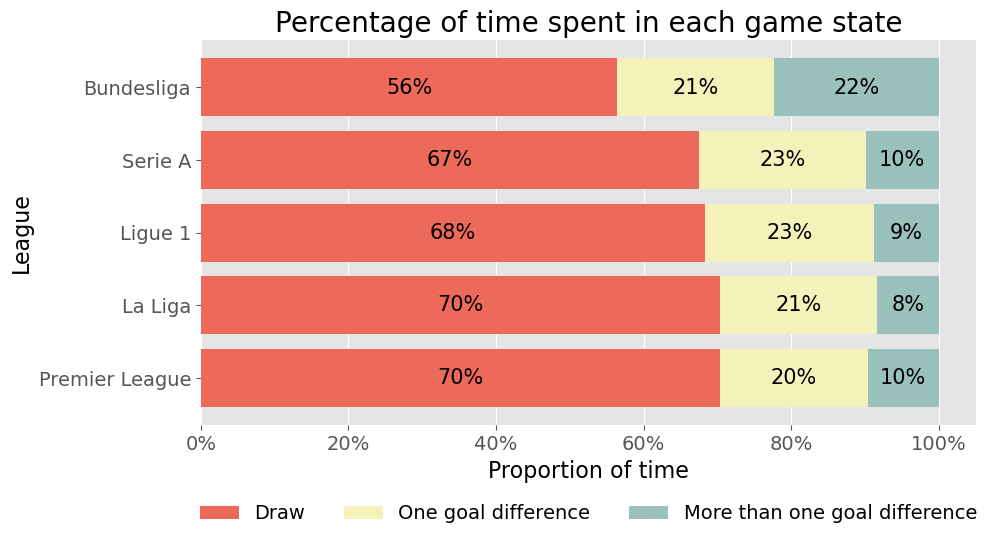

In [11]:
# plot the data barh
ax = zd.plot.barh(stacked=True, figsize=(10, 5), width=0.8, color=['#ED6A5A', '#F4F1BB', '#9BC1BC'])
# Show percentages on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(width), (x + width/2, y + height/2), ha='center', va='center', size=15)
plt.title("Percentage of time spent in each game state", size=20)
# change x axis to percentage
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel("Proportion of time", size=16, color='black')
plt.ylabel("League", size=16, color='black')
# legend under the plot
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=3, fontsize=14, frameon=False)
# add grid behind the plot
plt.grid(axis='y')
plt.xticks(size=14)
# larger y ticks
plt.yticks(size=14)

# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)


# save with transparent background and black borders
plt.savefig('goal_diff_analysis.png', bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=300)
plt.show()